In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [2]:
np.random.seed(1234)
import pystan
import scipy.stats as stats
import arviz as az

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

PyStan
====

Install `PyStan`  with
```
pip install pystan
```

The nice thing about `PyMC` is that everything is in Python. With `PyStan`, however, you need to use a domain specific language based on C++ syntax to specify the model and the data, which is less flexible and more work. However, in exchange you get an extremely powerful HMC package (only does HMC) that can be used in R and Python.

### Useful links

- [Paper describing Stan](http://www.stat.columbia.edu/~gelman/research/unpublished/stan-resubmit-JSS1293.pdf)
- [Stan Examples and Reference Manual](https://github.com/stan-dev/example-models/wiki)
- [PyStan docs](http://pystan.readthedocs.org/en/latest/)
- [PyStan GitHub page](https://github.com/stan-dev/pystan)

In [4]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

### Coin toss

We'll repeat the example of determining the bias of a coin from observed coin tosses. The likelihood is binomial, and  we use a beta prior.

In [5]:
%%capture

coin_code = """
data {
    int<lower=0> n; // number of tosses
    int<lower=0> y; // number of heads
}
transformed data {}
parameters {
    real<lower=0, upper=1> p;
}
transformed parameters {}
model {
    p ~ beta(2, 2);
    y ~ binomial(n, p);
}
generated quantities {}
"""

coin_dat = {
             'n': 100,
             'y': 61,
            }

sm = pystan.StanModel(model_code=coin_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77 NOW.


In [6]:
fit = sm.sampling(data=coin_dat, iter=1000, chains=1)

#### Loading from a file

The string in coin_code can also be in a file - say `coin_code.stan` - then we can use it like so

```python
fit = pystan.stan(file='coin_code.stan', data=coin_dat, iter=1000, chains=1)
```

In [7]:
print(fit)

Inference for Stan model: anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p       0.6  3.6e-3   0.05   0.51   0.57    0.6   0.64   0.69    178    1.0
lp__ -70.24    0.04   0.65 -71.91 -70.47 -69.95 -69.78 -69.74    271   1.01

Samples were drawn using NUTS at Thu Apr 16 22:17:21 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
coin_dict = fit.extract()
coin_dict.keys() 
# lp_ is the log posterior

odict_keys(['p', 'lp__'])

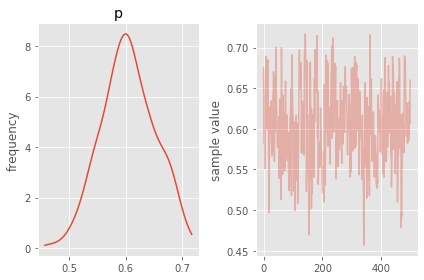

In [9]:
fit.plot('p');
plt.tight_layout()

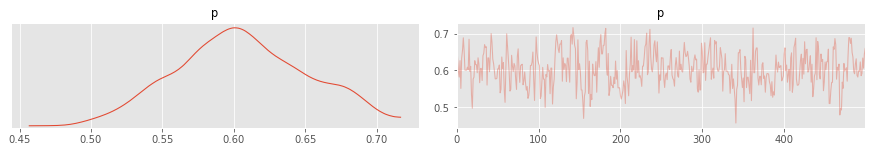

In [10]:
az.plot_trace(fit)
pass

### Estimating mean and standard deviation of normal distribution

$$
X \sim \mathcal{N}(\mu, \sigma^2)
$$

In [11]:
%%capture

norm_code = """
data {
    int<lower=0> n; 
    real y[n]; 
}
transformed data {}
parameters {
    real<lower=0, upper=100> mu;
    real<lower=0, upper=10> sigma;
}
transformed parameters {}
model {
    y ~ normal(mu, sigma);
}
generated quantities {}
"""

norm_dat = {
             'n': 100,
             'y': np.random.normal(10, 2, 100),
            }

sm = pystan.StanModel(model_code=norm_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3318343d5265d1b4ebc1e443f0228954 NOW.


In [12]:
fit = sm.sampling(data=norm_dat, iter=1000, chains=1)

In [13]:
fit

Inference for Stan model: anon_model_3318343d5265d1b4ebc1e443f0228954.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     10.07    0.01    0.2   9.72   9.92  10.07  10.21  10.47    329    1.0
sigma   2.03  7.8e-3   0.14   1.76   1.92   2.03   2.13   2.33    319    1.0
lp__  -117.1    0.05   0.87 -119.4 -117.6 -116.8 -116.4 -116.2    254    1.0

Samples were drawn using NUTS at Thu Apr 16 22:18:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [14]:
trace = fit.extract()

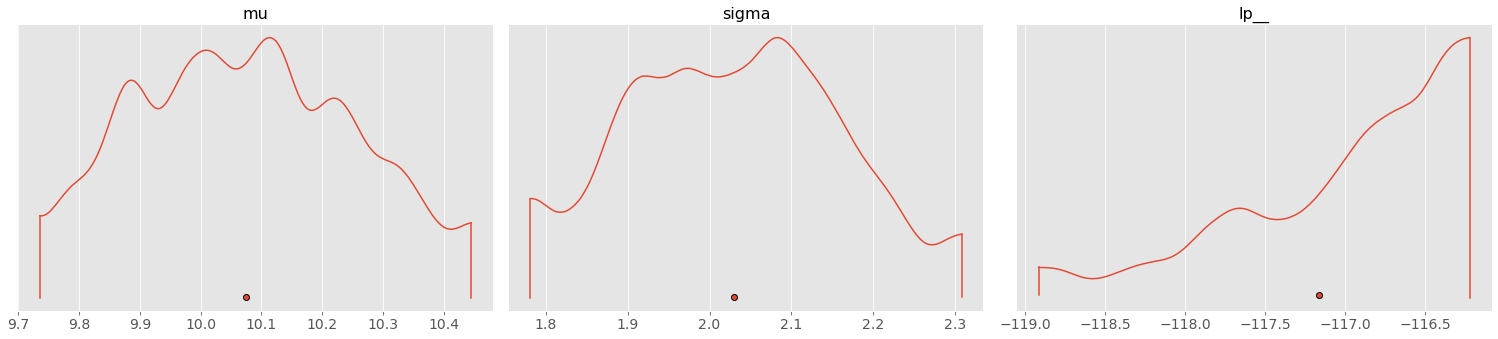

In [15]:
az.plot_density(trace)
pass

#### Optimization (finding MAP)

In [16]:
op = sm.optimizing(data=norm_dat)
op

OrderedDict([('mu', array(1.e-13)), ('sigma', array(10.))])

#### Reusing models

In [17]:
new_dat = {
             'n': 100,
             'y': np.random.normal(5, 1, 100),
            }

In [18]:
fit2 = sm.sampling(data=new_dat, chains=1)

In [19]:
fit2

Inference for Stan model: anon_model_3318343d5265d1b4ebc1e443f0228954.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.95  3.6e-3    0.1   4.75   4.88   4.95   5.01   5.14    760    1.0
sigma    1.0  2.7e-3   0.07   0.87   0.94   0.99   1.04   1.14    724    1.0
lp__  -47.41    0.04   0.97 -49.88 -47.83 -47.14 -46.72 -46.43    558    1.0

Samples were drawn using NUTS at Thu Apr 16 22:18:44 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

#### Saving compiled models

We can also compile Stan models and save them to file, so as to reload them for later use without needing to recompile.

In [20]:
def save(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))

In [21]:
%%capture

model = pystan.StanModel(model_code=norm_code)
save(model, 'norm_model.pic')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3318343d5265d1b4ebc1e443f0228954 NOW.


In [22]:
new_model = load('norm_model.pic')
fit4 = new_model.sampling(new_dat, chains=1)
fit4

Inference for Stan model: anon_model_3318343d5265d1b4ebc1e443f0228954.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.95  3.6e-3    0.1   4.77   4.88   4.95   5.03   5.15    790    1.0
sigma   0.99  2.3e-3   0.07   0.87   0.94   0.99   1.04   1.13    843    1.0
lp__  -47.39    0.04   0.93 -50.14 -47.76 -47.14 -46.73 -46.43    569    1.0

Samples were drawn using NUTS at Thu Apr 16 22:19:52 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

### Estimating parameters of a linear regression model

We will show how to estimate regression parameters using a simple linear model

$$
y \sim ax + b
$$

We can restate the linear model $$y = ax + b + \epsilon$$ as sampling from a probability distribution

$$
y \sim \mathcal{N}(ax + b, \sigma^2)
$$

We will assume the following priors

$$
a \sim \mathcal{N}(0, 100) \\
b \sim \mathcal{N}(0, 100) \\
\sigma \sim \mathcal{U}(0, 20)
$$

In [23]:
%%capture

lin_reg_code = """
data {
    int<lower=0> n; 
    real x[n];
    real y[n]; 
}
transformed data {}
parameters {
    real a;
    real b;
    real sigma;
}
transformed parameters {
    real mu[n];
    for (i in 1:n) {
        mu[i] <- a*x[i] + b;
        }
}
model {
    sigma ~ uniform(0, 20);
    y ~ normal(mu, sigma);
}
generated quantities {}
"""

n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

lin_reg_dat = {
             'n': n,
             'x': x,
             'y': y
            }

sm = pystan.StanModel(model_code=lin_reg_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4bdbb0aeaf5fafee91f7aa8b257093f2 NOW.


In [24]:
fit = sm.sampling(data=lin_reg_dat, iter=1000, chains=1)

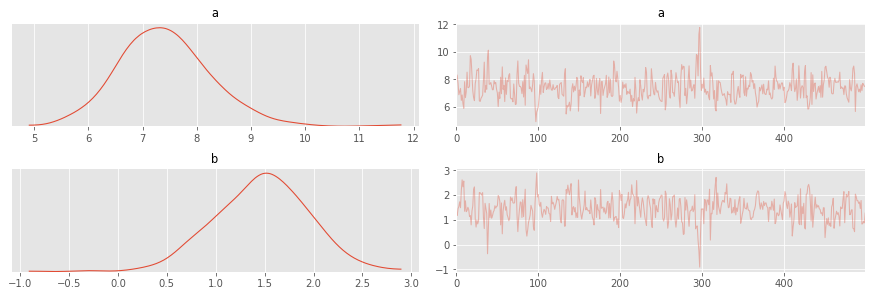

In [25]:
az.plot_trace(fit, ['a', 'b'])
pass

### Simple Logistic model

We have observations of height and weight and want to use a logistic model to guess the sex.

In [26]:
# observed data
df = pd.read_csv('data/HtWt.csv')
df.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [27]:
%%capture

log_reg_code = """
data {
    int<lower=0> n; 
    int male[n];
    real weight[n];
    real height[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    for(i in 1:n) {
        male[i] ~ bernoulli(inv_logit(a*weight[i] + b*height[i] + c));
  }
}
generated quantities {}
"""

log_reg_dat = {
             'n': len(df),
             'male': df.male,
             'height': df.height,
             'weight': df.weight
            }

sm = pystan.StanModel(model_code=log_reg_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bbf283522d1e199c049bb423b4a6e0da NOW.


In [28]:
fit = sm.sampling(data=log_reg_dat, iter=2000, chains=1)

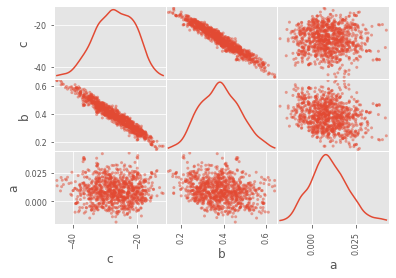

In [29]:
df_trace = pd.DataFrame(fit.extract(['c', 'b', 'a']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');